# **Capstone Project: Air Pollution Agent Robert**

Project link to my Github: https://github.com/RWong09/5-Day-Gen-AI-Intensive-Course-with-Google-Wong-Hoong-Liang-s-Edition-2025-/blob/main/Capstone-Project%20by%20Wong%20HL.ipynb 

Have you ever had any troubles knowing the Air Quality Index (AQI) of your area? Or do you need advice on how to prepare yourself from the air pollution? No worries! Air pollution agent, Robert will provide you the latest updates on air pollution and also giving you advice on everything about air pollution.

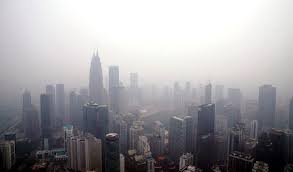
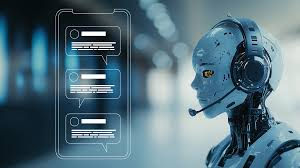
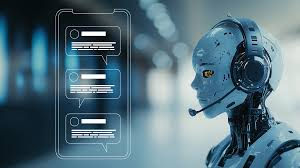
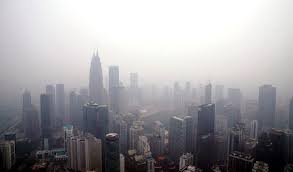

# **Setup**

**Before you install the packages, please add the following dataset into your input before proceed to run the cells.**

1. Go to file
2. Select 'Add Input'
3. Add this dataset (Search the link): https://www.kaggle.com/datasets/kanchana1990/world-air-quality-data-2024-updated
4. Add the dataset by pressing '+' sign

You will get this:

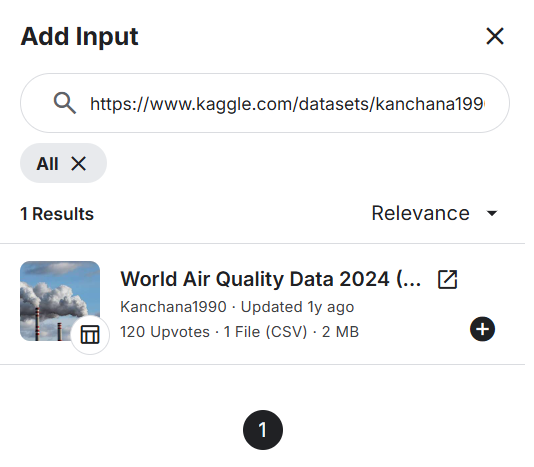

All the setup packages required for building the agent:

In [1]:
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
!pip install --quiet pymupdf
!pip install --quiet python-docx
!pip install -U -q "google-genai==1.7.0"
!pip install -qU 'langchain-google-genai==2.1.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 69.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requires jupyterlab<4.0.0a0,>=3.1.0, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 19.8 MB/s eta 0:00:00


In [2]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display, Image

genai.__version__

'1.7.0'

In [3]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import sqlite3
import fitz  # PyMuPDF for PDFs
import PIL
from docx import Document
from datetime import datetime
from PIL import Image
from IPython.display import display, Markdown
from langchain.tools import Tool

# **Few shot prompt**

This few shot prompt is used so that the agent is able to learn and able to provide the correct answers regarding air pollution. It is to test whether the model used can learn the examples well and answer the following questions correctly.

In [6]:
few_shot_prompt_airPollution="""
    Generates a descriptive visual prompt based on the given Air Quality Index (AQI).

    Args:
        aqi (int): The Air Quality Index value.

    Returns:
        str: A textual description representing what the environment might look like 
             at the specified AQI level. Useful for generating or interpreting images 
             related to air pollution levels.
    
    if aqi < 50:
        return "Clear sky over a clean, green city with visible skyline and parks."
    elif aqi < 100:
        return "A moderately hazy city with light pollution visible in the atmosphere."
    elif aqi < 200:
        return "City under a noticeable haze with a yellowish sky and low visibility."
    else:
        return "Heavily polluted urban area with smog, dark skies, and face-mask-wearing people."
    """

user_prompt = "Describe the scene in Penang where aqi is 75."

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt_airPollution, user_prompt])

display(Markdown(f"{response.text}"))    

A moderately hazy view of Georgetown, Penang. The iconic Komtar tower is visible but slightly blurred in the distance. Light pollution creates a subtle glow in the sky above the city, obscuring some of the stars. The coastline is still discernible, but the details of the beaches and distant islands are softened by the haze.


# **GenAI Evaluation**

In this section, we evaluated the performance of the model used before we proceed with the agent building. This can be done by building a latency and respond function of the model so that it shows how accurately the model got the city matched with the data provided. Then, it also prints out the latency of the model to show the efficiency of the model in answering the questions.

First, we load up the dataset:

In [7]:
df = pd.read_csv('/kaggle/input/world-air-quality-data-2024-updated/world_air_quality.csv',sep=';')
df.dropna(inplace=True)

#Remove extra spaces
df.columns = df.columns.str.strip()
df.head()

,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label
195,LA,Bueng Kan,Bueng Kan District Office,"18.358249, 103.652055",CO,Air4Thai,ppm,2.670,2023-06-13T05:30:00+05:30,Lao People's Dem. Rep.
196,LT,Integrated Monitoring Network,NET-LT002A,"55.46333312949894, 26.004169460000004",PM2.5,EEA Lithuania,µg/m³,2.200,2024-03-11T16:30:00+05:30,Lithuania
197,LT,National Air Monitoring Network,NET-LT001A,"55.68999999950047, 21.17946",CO,EEA Lithuania,µg/m³,209.556,2024-03-11T16:30:00+05:30,Lithuania
198,LU,Air Quality Luxembourg,NET-LU005A,"49.61156999947028, 6.118470000000001",NO2,EEA Luxemburg,µg/m³,10.700,2024-03-11T17:30:00+05:30,Luxembourg
199,LU,Air Quality Luxembourg,NET-LU005A,"49.505039999469965, 5.97694",PM2.5,EEA Luxemburg,µg/m³,8.000,2024-03-11T17:30:00+05:30,Luxembourg


In [8]:
def measure_latency_and_respond(model_function, *args, **kwargs):
    start_time = time.time()
    response = model_function(*args, **kwargs)
    latency = time.time() - start_time
    return response, latency

In [9]:
def evaluate_response(user_query: str, model_response: str, expected_keywords: list, source_df: pd.DataFrame, latency: float, city_col='City') -> dict:
    """
    Evaluates GenAI responses for factual accuracy, relevance, completeness, and tracks latency.
    """
    
    # City match (simple check)
    matched_city = None
    for city in source_df[city_col].unique():
        if city.lower() in user_query.lower():
            matched_city = city
            break

    # Check if model used expected keywords
    keyword_score = sum(1 for kw in expected_keywords if kw.lower() in model_response.lower()) / len(expected_keywords)

    # Check against actual data (e.g., PM2.5 value)
    factual_score = None
    if matched_city:
        actual_row = source_df[source_df[city_col] == matched_city].iloc[0]
        pm25_actual = actual_row.get("PM2.5")
        if pd.notna(pm25_actual):
            factual_score = "PM2.5" in model_response and str(int(pm25_actual)) in model_response
        else:
            factual_score = "PM2.5" in model_response

    # Summary
    return {
        "City_detected": matched_city,
        "Keyword_coverage": f"{keyword_score*100:.0f}%",
        "Factual_match": factual_score if factual_score is not None else "N/A",
        "latency_seconds": f"{latency:.2f}s",
        "Comments": "Looks good!" if keyword_score > 0.8 and factual_score else "Needs improvement"
    }

In [10]:
response_obj, latency_result = measure_latency_and_respond(lambda: client.models.generate_content(
    model="gemini-2.0-flash",
    contents=["What is the PM2.5 level in Delhi?"],
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=1000,
    )
))

# Extract text from the response
model_answer = ""
for part in response_obj.candidates[0].content.parts:
    if part.text:
        model_answer += part.text + "\n"
model_answer = model_answer.strip()

eval_result = evaluate_response(
    user_query="What is the PM2.5 level in Delhi?", 
    model_response=model_answer,
    expected_keywords=["PM2.5", "Delhi"], 
    latency=latency_result,
    source_df=df  
)

for key, value in eval_result.items():
    print(f"{key}: {value}")

display(Markdown(model_answer))

City_detected: Delhi
Keyword_coverage: 100%
Factual_match: True
latency_seconds: 2.40s
Comments: Looks good!


I cannot give you a real-time PM2.5 level for Delhi. Air quality changes very rapidly.

However, here's how you can find the information:

*   **Reliable Air Quality Websites/Apps:**
    *   **Central Pollution Control Board (CPCB) Website:** The official source for Indian air quality data.
    *   **SAFAR-India:** (System of Air Quality and Weather Forecasting and Research) - Another Indian government initiative.
    *   **World Air Quality Index (WAQI):** A popular global site that aggregates data from various sources.
    *   **BreezoMeter:** A commercial service that provides detailed air quality information.
    *   **AirVisual:** Another popular global air quality monitoring platform.
    *   **Your Phone's Weather App:** Many weather apps now include air quality information.

**When you check, look for:**

*   **The specific location:** Delhi is a large city, and air quality can vary significantly from neighborhood to neighborhood. Look for data from a monitoring station near where you are interested in.
*   **The time of the reading:** Air quality changes throughout the day. Make sure the reading is recent.
*   **The AQI (Air Quality Index) value:** This is a simplified number that tells you how healthy or unhealthy the air is.
*   **The PM2.5 concentration (in micrograms per cubic meter - µg/m³):** This is the actual measurement of fine particulate matter.

Be aware that different sources may use slightly different calculation methods for the AQI, so there might be minor variations between them. However, they should all give you a general idea of the air quality.

Well, seems like the bot is able to mention the facts and city correctly. But there seems to be some problems where the bot cannot provide real-time update or even retrieve the information from the dataset in order to provide the updates or PM2.5 levels in Delhi to user. Maybe we try to find tune and build some useful tools to our agent.

# **Understanding Documents Given by the User**

We built a function where the agent is able to read the file path prompted by the user and if the file type is a document, the agent will read the document and provide insights and suggesttion, or even summarize the documents about air pollution to the users.

In [11]:
def read_document(file_path):
    """
    Uses Gemini to analyze documents related to air pollution,
    then provide insights or suggestions, or summarize the document based on user's request.
    """
    if file_path.endswith('.txt'):
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read()
    elif file_path.endswith('.pdf'):
        doc = fitz.open(file_path)
        return "\n".join([page.get_text() for page in doc])
    elif file_path.endswith('.docx'):
        doc = Document(file_path)
        return "\n".join([para.text for para in doc.paragraphs])
    else:
        raise ValueError("Unsupported file type")

In [12]:
!wget -nv https://www.greenpeace.org/static/planet4-india-stateless/2024/03/44a856c8-2023_world_air_quality_report.pdf -O report.pdf
document_text = read_document("report.pdf")

prompt = f"""
Here is a recent report on air pollution:

{document_text[:3000]}  # Truncate if too long

Can you summarize key concerns and mention which cities are most affected?
"""
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.0,
        max_output_tokens=1000,
    ),
    contents=prompt)

display(Markdown(f"{response.text}")) 

2025-04-19 10:33:47 URL:https://www.greenpeace.org/static/planet4-india-stateless/2024/03/44a856c8-2023_world_air_quality_report.pdf [2966280/2966280] -> "report.pdf" [1]


Based on the provided table of contents, the 2023 World Air Quality Report likely focuses on PM2.5 pollution. Here's a summary of key concerns and potentially affected cities, based on the table of contents:

**Key Concerns (Inferred from Table of Contents):**

*   **High PM2.5 Levels:** The report centers around PM2.5, a dangerous air pollutant, suggesting high levels are a primary concern.
*   **Regional Disparities:** The report breaks down air quality by region (East Asia, Southeast Asia, Central & South Asia, West Asia), indicating significant differences in pollution levels across the globe.
*   **Climate Change Link:** The report explicitly mentions the relationship between climate change and air pollution, suggesting that climate change is exacerbating air quality issues.
*   **Public Monitoring Status:** The inclusion of this section suggests a concern about the availability and quality of air quality monitoring data in different regions.

**Potentially Most Affected Cities (Inferred from Table of Contents):**

The report includes rankings for both countries/regions and capital cities. Therefore, the most affected cities are likely to be found in:

*   **Countries/Regions with High Rankings:** Based on the table of contents, the report ranks countries/regions by PM2.5 levels. The countries/regions at the top of this ranking (likely in Central & South Asia, East Asia, and Southeast Asia based on the regional summaries) are likely to contain the most polluted cities.
*   **Top-Ranked Capital Cities:** The report specifically ranks world capital cities by air quality. The capital cities at the top of this ranking are likely among the most polluted globally.

**Specific Countries/Regions and Cities to Watch (Based on Table of Contents):**

*   **East Asia:** China, South Korea
*   **Southeast Asia:** Indonesia, Malaysia, Thailand, Vietnam
*   **Central & South Asia:** Bangladesh, India, Pakistan

The report likely contains specific data on cities within these countries/regions that are experiencing the worst air quality. The "2023 World capital city ranking" section will provide a direct list of the most polluted capital cities.


Wow, look at that! It summarizes the key points and mentions the most important cities that are affected by the air pollutions. It seems like the model understands the document well.

# **Google Ground Search**

Now, we are going to enable Google Ground search function to the model and build into the agent as part of the functions so that the agent can access to the latest information about air pollution for the user. It can also provide links and URLs as reference to the user.

In [13]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def search_with_grounding(content:str):
    """
    Uses Gemini to provide links, HTMLs or any sources to the user as reference to the output or answer given.
    """
    
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=content,
        config=config_with_search,
    )
    return response.candidates[0]

question="What is the current air quality index in Kuala Lumpur?"
rc = search_with_grounding(question)
Markdown(rc.content.parts[0].text)

#Include links that supports the answer
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = search_with_grounding(question)

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

HTML(rc.grounding_metadata.search_entry_point.rendered_content)

aqi.in: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAL5OiiZe7SEVmvuh5sik0TyxN_UGZsSlJ4rJqF6MYRIhg9rvByD5uVQC2XCq3radYpBQRuqqKhluhjf6OKtI0fEEtoj1il2WmfDgtmVB1paRFiEVdITTIscyz0XK6-ShYbdVEo9XtlHsRdK7UAAkS8=
aqi.in: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJnnQGWk5YEXBAbROsiulyz6bDy_tysnFFC4S2WBVvbOVmlGanY27CbGcIuskINDGvL5Sjand0UBq_6Gvgpoq-htMwxXcPEjUBIQC-5hxt42U64lOlpD1d-QVZXScA-jDKiER1ufCbHZW1TY6Xyknl4DRWQMTi59uZAtC1c
accuweather.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALnWyuG4KIrAq2CLEKqZWaZXNHOBohZ07uGTN-eLfhQPAQzpNf9AWMME8rQR4KEjVVq4-bogwyF_JB69nXVEYQ_WgTEFD0iCGcVo_eWFwAseR-03s0T6Da7pGbXQgk6XMpF54Viz3_qzi6TjSM-Ni0n90M1XrdRbsmbKdRonQ-6rX4f7BI1gdnw


In [14]:
def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())

    display(Markdown('----'))

user_message = "What were the top 10 most polluted countries and cities in 2024? Please provide it separately in country and city categories."

response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=user_message,
        config=config_with_search,
    )

#Display the response
show_response(response)

Here are the top 10 most polluted countries and cities in 2024, based on available reports:

**Most Polluted Countries (2024):**

1.  Chad
2.  Bangladesh
3.  Pakistan
4.  Democratic Republic of Congo
5.  India
6.  Egypt
7.  United Arab Emirates
8.  Kuwait
9.  Tajikistan
10. Kyrgyzstan

**Most Polluted Cities (2024):**

While different reports provide slightly varying lists, here's a consolidated list based on the available information, with a focus on PM2.5 levels:

1.  Byrnihat, India
2.  New Delhi, India
3.  Ghaziabad, Uttar Pradesh, India
4.  Greater Noida, Uttar Pradesh, India
5.  Noida, Uttar Pradesh, India
6.  Faridabad, Haryana, India
7.  Gurgaon, Haryana, India
8.  Bhiwadi, Rajasthan, India
9.  Dhaka, Bangladesh
10. Sonipat, Haryana, India


----

Here, the model is able to provide the information even up to 2024, this makes the agent to get up-to-date information to the users and provide relevant suggestions based on the information provided.

# **Log Queries and Outputs into SQLite**

This section enables the chat between the user and the agent to be logged into the SQLite database so that the agent can retrieve the information from SQLite database and continue the conversation to the user.

In [15]:
#Code to measure latency (This part is modified so that the function can return the output and display it to the user)

def measure_latency_and_responding(model_function, *args, **kwargs):
    start_time = time.time()
    response = model_function(*args, **kwargs)
    latency = time.time() - start_time

    # Flatten text response
    output_text = ""
    try:
        parts = response.candidates[0].content.parts
        for p in parts:
            if hasattr(p, "text") and p.text:
                output_text += p.text + "\n"
            elif hasattr(p, "inline_data"):
                output_text += "[Image/Inline data rendered]\n"
    except Exception as e:
        output_text = f"[Error parsing response] {str(e)}"

    return response, output_text.strip(), latency

First, we will initialize a table where it can record:
1. Timestamp of the chat
2. User's input
3. Type of chat
4. Output from the agent
5. Latency

In [16]:
# Initialize or connect to the database
conn = sqlite3.connect("air_pollution_agent_log.db")
cursor = conn.cursor()

# Create table if it doesn't exist
cursor.execute("""
CREATE TABLE IF NOT EXISTS logs (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp TEXT,
    input TEXT,
    type TEXT,
    output TEXT,
    latency REAL
)
""")
conn.commit()

Then, we include some functions like logging the chats into the databse, viewing the logs and clearing the logs.

In [17]:
#Logging function
def log_interaction(user_input, input_type, output_text, latency):
    timestamp = datetime.now().isoformat()
    cursor.execute("""
        INSERT INTO logs (timestamp, input, type, output, latency)
        VALUES (?, ?, ?, ?, ?)
    """, (timestamp, user_input, input_type, output_text, latency))
    conn.commit()

#View the logs from the database
def view_logs(limit=10):
    rows = cursor.execute("SELECT * FROM logs ORDER BY id DESC LIMIT ?", (limit,)).fetchall()
    for row in rows:
        print(f"---\n[{row[1]}] ({row[3]})\nInput: {row[2]}\nOutput: {row[4][:300]}...\nLatency: {row[5]:.2f}s\n")

#Enable users to clear the logs
def clear_logs():
    confirm = input("⚠️ Are you sure you want to delete all logs? Type 'yes' to confirm: ")
    if confirm.lower() == 'yes':
        cursor.execute("DELETE FROM logs")
        conn.commit()
        print("✅ All logs cleared.")
    else:
        print("❌ Clear cancelled.")

Before we test the function, we will clear the logs from the database to make sure only our testing examples will be logged and viewed later.

In [18]:
#Clear the log before the test
clear_logs()

⚠️ Are you sure you want to delete all logs? Type 'yes' to confirm:  yes


✅ All logs cleared.


In [19]:
#Test the function
user_message = "What were the top 10 most polluted countries and cities in 2024? Please provide it separately."

# Send Gemini message and track response + latency
response, answer, latency = measure_latency_and_responding(
    lambda: client.models.generate_content(
        model='gemini-2.0-flash',
        contents=[user_message],
        config=config_with_search
    )
)

# Log it
log_interaction(user_message, "text_with_grounding", answer, latency)

# Display it
show_response(response)

According to the 2024 World Air Quality Report by IQAir, here are the most polluted countries and cities:

**Most Polluted Countries (2024):**

1.  Chad
2.  Bangladesh
3.  Pakistan
4.  Democratic Republic of Congo
5.  India

**Most Polluted Cities (2024):**

While a definitive list of the top 10 most polluted cities globally is difficult to compile from the search results, some of the most polluted cities mentioned are:

*   Byrnihat, India (most polluted metropolitan area)
*   Delhi, India (most polluted capital city)
*   New Delhi, India
*   Ghaziabad, Uttar Pradesh, India
*   Greater Noida, Uttar Pradesh, India
*   Noida, Uttar Pradesh, India
*   Faridabad, Haryana, India
*   Bhiwadi, Rajasthan, India
*   Gurgaon, Haryana, India
*   Dhaka, Bangladesh
*   Sonipat, Haryana, India
*   Peshawar, Khyber Pakhtunkhwa, Pakistan



----

In [20]:
#View the log
view_logs()

---
[2025-04-19T10:34:41.923952] (text_with_grounding)
Input: What were the top 10 most polluted countries and cities in 2024? Please provide it separately.
Output: According to the 2024 World Air Quality Report by IQAir, here are the most polluted countries and cities:

**Most Polluted Countries (2024):**

1.  Chad
2.  Bangladesh
3.  Pakistan
4.  Democratic Republic of Congo
5.  India

**Most Polluted Cities (2024):**

While a definitive list of the top 10 mos...
Latency: 3.00s



The table seems to work perfectly, all the functions such as clearing log, viewing log and logging the chat are working perfectly as it should.

# **Chain of thoughts with image understanding**

In this section, we are going to build a tool where the agent can analyse the media such as images and URLs provided by the user, and using Chain of Thoughts (CoT) to provide a correct answer and output to the user.

In [21]:
def analyze_airPollution_media(user_prompt: str):
    """
    Uses Gemini to analyze an image or news link related to air pollution,
    then reasons through it using Chain-of-Thought and provides insights or suggestions.
    """

    is_local_image = user_prompt.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.webp'))
    is_web_image = re.search(r'(https?:\/\/.*\.(?:png|jpg|jpeg|gif|webp))', user_prompt)
    is_newsLink = re.search(r'https?:\/\/[^\s]+', user_prompt) and not is_web_image

    response_text = ""
    latency = 0

    try:
        if is_local_image:
            img = Image.open(user_prompt)
            prompt = [
                "Analyze this image carefully. What does it indicate about air quality or pollution? "
                "Consider visual cues (like haze, sky color, vehicles, smog) and provide step-by-step reasoning. "
                "Give suggestions if applicable.",
                img
            ]

            start_time = time.time()
            response = client.models.generate_content(model='gemini-2.0-flash', contents=prompt)
            latency = time.time() - start_time

            response_text = response.text
            display(Markdown(f"### 📷 Image Analysis Result:\n\n{response_text}"))

            # Log the local image interaction
            log_interaction(user_prompt or "[image]", "image", response_text, latency)

        elif is_web_image:
            try:
                img_url = is_web_image.group(1)
                img_response = requests.get(img_url)
                img = Image.open(BytesIO(img_response.content))

                prompt = [
                    "Analyze this image carefully. What does it indicate about air quality or pollution? "
                    "Consider visual cues (like haze, sky color, vehicles, smog) and provide step-by-step reasoning. "
                    "Give suggestions if applicable.",
                    img
                ]

                start_time = time.time()
                response = client.models.generate_content(model='gemini-2.0-flash', contents=prompt)
                latency = time.time() - start_time

                response_text = response.text
                display(Markdown(f"### 🌐 Web Image Analysis Result:\n\n{response_text}"))

                # Log the web image interaction
                log_interaction(user_prompt, "image", response_text, latency)

            except Exception as e:
                display(Markdown(f"**❌ Error downloading or opening the image:** {str(e)}"))
                return

        elif is_newsLink:
            prompt = f"""
            You are an expert air pollution assistant. A user has shared this news link:

            "{user_prompt}"

            Step-by-step, analyze the content based on air pollution patterns, sources, and health impacts.

            Then, give your suggestions or insights on what the user can do or be aware of in relation to this.

            Return a clear, human-friendly explanation and any actionable tips.
            """

            start_time = time.time()
            response = client.models.generate_content(model='gemini-2.0-flash', contents=prompt)
            latency = time.time() - start_time

            response_text = response.text
            display(Markdown(f"### 🌐 URL-Based Analysis Result:\n\n{response_text}"))

            # Log the news link analysis
            log_interaction(user_prompt, "text_or_url", response_text, latency)

        else:
            display(Markdown("⚠️ Input does not appear to be a valid image or URL."))
    
    except Exception as e:
        display(Markdown(f"**❌ Unexpected error during analysis:** {str(e)}"))

We test the function by downloading an image as an example and prompt it to the model.

In [22]:
!wget -nv https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Haze_in_Kuala_Lumpur.jpg/330px-Haze_in_Kuala_Lumpur.jpg -O haze_kl.jpg
analyze_airPollution_media("haze_kl.jpg")

2025-04-19 10:34:42 URL:https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Haze_in_Kuala_Lumpur.jpg/330px-Haze_in_Kuala_Lumpur.jpg [11330/11330] -> "haze_kl.jpg" [1]


### 📷 Image Analysis Result:

Here's an analysis of the image regarding air quality:

**Step-by-step Reasoning:**

1.  **Visual Cue: Haze/Smog:** The most prominent feature is the thick haze obscuring the cityscape.  Distant buildings are barely visible, and even the nearer structures lack sharpness. This indicates a significant amount of particulate matter or other pollutants in the air.
2.  **Visual Cue: Sky Color:** The sky is not blue, but a murky gray/yellowish-brown color. This discoloration is a telltale sign of air pollution, as clean air would allow the natural blue color to be visible.
3.  **Context Clues:** The cityscape indicates an urban area. Cities are often sources of air pollution due to:
    *   **Vehicle Emissions:** Cars, trucks, and buses release exhaust fumes containing pollutants like nitrogen oxides and particulate matter.
    *   **Industrial Activity:** Factories and power plants can emit a variety of pollutants.
    *   **Construction:** Dust and other particulate matter are released during construction activities.
4. **Analysis of the Scene:**
    *   **Dominant Feature:**  The thick haze enveloping the entire scene is the most indicative sign.  It is severe enough to dramatically reduce visibility.
    *   **Color:** The sky's color is very unnatural and suggests a high concentration of air pollutants absorbing and scattering light.

**Conclusion about Air Quality:**

Based on the visual evidence, the image suggests **poor air quality**.  The thick haze, discolored sky, and urban context all point to significant air pollution. The air quality is likely unhealthy for sensitive groups (children, elderly, individuals with respiratory issues) and may even be hazardous for the general population.

**Suggestions:**

1.  **Identify the Pollutants:** To confirm the kind and level of pollutants, an examination of local air quality data is needed. The image is just a visual clue and doesn't reveal specifics (e.g., PM2.5, ozone, sulfur dioxide levels).
2.  **Investigate Sources:** Identify the sources of the pollution. Are there major industrial plants, heavy traffic, or seasonal factors (like agricultural burning) contributing to the problem?
3.  **Implement Mitigation Measures:** Depending on the source of the pollution, consider:
    *   **Stricter emissions standards for vehicles and industries.**
    *   **Promoting public transportation and cycling.**
    *   **Investing in renewable energy sources.**
    *   **Dust control measures at construction sites.**
    *   **Awareness campaigns to educate the public about air pollution and how to reduce their impact.**
4.  **Monitor and Report:** Establish continuous air quality monitoring stations and regularly report the data to the public.



Great! The model seems to be able to have a thought process by using step-by-step reasoning before making a conclusion. It also provides some useful suggestion to the users on how to prevent air pollution based on the image analysis.

Since the CoT function also includes logging the interactions into the database, we will view the log to see whether it exists in the table.

In [23]:
#View the log again
view_logs()

---
[2025-04-19T10:34:46.403336] (image)
Input: haze_kl.jpg
Output: Here's an analysis of the image regarding air quality:

**Step-by-step Reasoning:**

1.  **Visual Cue: Haze/Smog:** The most prominent feature is the thick haze obscuring the cityscape.  Distant buildings are barely visible, and even the nearer structures lack sharpness. This indicates a significant...
Latency: 3.97s

---
[2025-04-19T10:34:41.923952] (text_with_grounding)
Input: What were the top 10 most polluted countries and cities in 2024? Please provide it separately.
Output: According to the 2024 World Air Quality Report by IQAir, here are the most polluted countries and cities:

**Most Polluted Countries (2024):**

1.  Chad
2.  Bangladesh
3.  Pakistan
4.  Democratic Republic of Congo
5.  India

**Most Polluted Cities (2024):**

While a definitive list of the top 10 mos...
Latency: 3.00s



It works! Along with the previous test log.😎

# **Building function calling tools**

With everything works perfectly, now we will try to build some extra functions to the agent such as query_air_quality, which returns air quality data for the given city if it is available in the dataset provided in a structured format, and also visualise_data which returns the graph (or provide a code for the user to visualise it) to the user based on the dataset given.

In [24]:
def query_air_quality(city: str):
    """Returns air quality data for the given city if available in the dataset."""
    city_data = df[df['City'].str.lower() == city.lower()]
    return city_data.to_dict(orient='records') if not city_data.empty else f"No data for {city}."

def visualise_data(city: str):
    """Returns graph for air pollution data of the given city if available in the dataset."""
    city_data = df[df['City'].str.lower() == city.lower()]
    if city_data.empty:
        return "No data to visualize."

    city_data = city_data.iloc[0]
    pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO']
    values = [city_data[p] for p in pollutants]

    plt.figure(figsize=(10,5))
    plt.bar(pollutants, values, color='orange')
    plt.title(f'Pollution levels in {city}')
    plt.ylabel('µg/m³ or ppm')
    plt.grid(True)
    plt.savefig('pollution_chart.png')
    return "Visualization generated as 'pollution_chart.png'"

Now, we build a tools set so that it is integrated into our agent later.🤖

In [25]:
tools = [
    Tool.from_function(
        func=query_air_quality,
        name="query_air_quality",
        description="Use this tool to get air quality metrics (like PM2.5) for a specific city from the dataset."
    ),
    Tool.from_function(
        func=visualise_data,
        name="visualise_data",
        description="Use this tool to generate charts about air pollution levels from the dataset."
    ),
    Tool.from_function(
        func=analyze_airPollution_media,
        name="analyze_airPollution_media",
        description="Use this tool to analyze images or URLs related to air pollution using Gemini Vision."
    ),
    Tool.from_function(
        func=search_with_grounding,
        name="search_with_grounding",
        description="Use this tool to answer a question using Google Search and include source URLs."
    ),
    Tool.from_function(
        func=read_document,
        name="read_document",
        description="Use this tool to read and extract text from PDF, TXT, or DOCX documents."
    )
]

Now, everything has been set. We can now build a chatbot that includes all the function!💯

The function in the bot includes:
1. Display the chat in a **structured format**
2. **Logging all the chat history** into the database and **retrieve it** so that the conversation with the user is smooth and able to remember the previous context to proceed further questions from the user.
3. **Google Ground Search** function to have the latest, most relevant information provided to the user.
4. To have **Chain of Thoughts (CoT)** to have step-by-step reasoning and provide more accurate answer to the user.
5. Able to analyse various medias such as **documents, pictures and also URLs** provided by the user.
6. **Provide relevant and related URLs and links** to the user as reference to their answers and outputs.

In [26]:
#Display the output in a structured format
def md(text):
    display(Markdown(text))

def run_chatbot():
    # Clear logs on session start
    try:
        cursor.execute("DELETE FROM logs")
        conn.commit()
        md("🧹 _Previous logs cleared. Starting a fresh session._")
    except Exception as e:
        md(f"⚠️ **Failed to clear logs**:\n```\n{e}\n```")
        
    md("## 👋 Hello, my name is **Robert**\nI am a smart AI agent to answer your questions about **air pollution**! 🌍")
    
    # Retrieve memory from SQLite
    def get_recent_context(n=10):
        rows = cursor.execute(
            "SELECT input, output FROM logs ORDER BY id DESC LIMIT ?", (n,)
        ).fetchall()
        context = ""
        for row in reversed(rows):
            context += f"User: {row[0]}\nRobert: {row[1]}\n"
        return context.strip()

    while True:
        user_input = input("Type your question below or type 'q' to quit. 😁\n")

        if user_input.lower() in ['q', 'quit']:
            md("### 👋 Quitting the session...\nThanks for using **Robert**, your smartest air quality assistant. See you next time! 😊")
            break

        try:
            memory_context = get_recent_context()
            full_prompt = f"{memory_context}\nUser: {user_input}\nRobert:"

            response, bot_answer, bot_latency = measure_latency_and_responding(
                lambda: client.models.generate_content(
                    model='gemini-2.0-flash',
                    contents=[full_prompt],
                    config=config_with_search
                )
            )
            
            # Display the response in markdown format
            md(f"---\n### 🤖 Robert says:\n{bot_answer.strip()}")

            # Log the chats into SQLite
            log_interaction(user_input, "text_with_grounding", bot_answer.strip(), bot_latency)

            # Show grounding sources in markdown format
            grounding_info = response.candidates[0].grounding_metadata
            if grounding_info and grounding_info.grounding_chunks:
                source_list = "\n".join(
                    f"- [{chunk.web.title}]({chunk.web.uri})"
                    for chunk in grounding_info.grounding_chunks
                )
                md(f"**🔗 Sources:**\n{source_list}")

        except Exception as e:
            md(f"⚠️ **Error occurred**:\n```\n{e}\n```")

In [27]:
run_chatbot()

🧹 _Previous logs cleared. Starting a fresh session._

## 👋 Hello, my name is **Robert**
I am a smart AI agent to answer your questions about **air pollution**! 🌍

Type your question below or type 'q' to quit. 😁
 Hi, what can you do?


---
### 🤖 Robert says:
Hallo! I can provide summaries, answer questions using information from provided sources, generate different creative text formats (like poems, code, scripts, musical pieces, email, letters, etc.), translate languages, and answer your questions in an informative way.

Type your question below or type 'q' to quit. 😁
 Can you show me the AQI index in Kuala lumpur?


---
### 🤖 Robert says:
Okay, here's the AQI (Air Quality Index) for Kuala Lumpur, based on the search results:

*   **Real-time AQI:** Different sources provide slightly different AQI values: 53 (Moderate), 55 (Moderate), 70 (Poor), and 34 (Fair).
*   **Dominant Pollutant:** PM2.5 (Fine Particulate Matter) is often listed as the dominant pollutant.
*   **Health Recommendations:** When the AQI is poor, it's generally advised to limit outdoor activities, especially for sensitive groups. Using an air purifier indoors and staying hydrated can also help.

**🔗 Sources:**
- [wunderground.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJAukLEty8NqPF4D6wkNL3rAVWqsnrCiaUQWHXXInm7nLLs2zFqkDGuVeNuD16Jy1JdaAyqvhS_bA5EPdf2TJGq0ugJX2VlDNQBTg3mQo100OHU86PxEOSwf1x0zKri4XRdqfjMyUQ1piKhI2ZXOrFLngSyMNeZ_koJ0JNt605xQ78FYr2fuNf_Ke5PvOaOzM-lIScAalg7ww56ojHWv7vox0r1hLl_9DiazxsaD_l-JDB5Iw==)

Type your question below or type 'q' to quit. 😁
 Can I know what are the effects of air pollution to the environment?


---
### 🤖 Robert says:
Air pollution has numerous harmful effects on the environment, including:

*   **Acid Rain:** Air pollutants like nitrogen oxides and sulfur oxides, released when fossil fuels are burned, can cause acid rain. This precipitation, containing nitric and sulfuric acids, damages trees, acidifies soils and water bodies (making them unsuitable for fish and wildlife), and speeds up the decay of buildings and statues.
*   **Eutrophication:** Excessive nitrogen from air emissions can enter aquatic ecosystems, leading to eutrophication. This condition stimulates algal blooms, which can cause fish kills and reduce plant and animal diversity.
*   **Haze and Reduced Sunlight:** Particulate pollution reduces the amount of sunlight reaching the surface, impacting photosynthesis in forests and crops, slowing their growth, and reducing yields. Haze also reduces visibility.
*   **Ozone Depletion:** While ozone in the stratosphere protects the Earth from harmful UV rays, ground-level ozone is a pollutant that can damage vegetation and ecosystems. Increased UV radiation can also harm sensitive crops.
*   **Damage to Ecosystems and Biodiversity:** Air pollution can degrade both terrestrial and aquatic ecosystems, reducing biodiversity. It can directly damage plants and animals, contaminate soil and water, and disrupt the balance of ecosystems. For example, nitrogen deposition can cause imbalances in plant composition, where nitrogen-loving plants outgrow others, reducing overall biodiversity.
*   **Climate Change:** Certain air pollutants, such as black carbon and tropospheric ozone, contribute to climate change by accelerating global warming. Greenhouse gas pollution leads to ocean acidification, harming marine life and ecosystems.
*   **Harm to Wildlife:** Animals can experience health problems, including birth defects and reproductive failure, from exposure to air toxics. Persistent pollutants can accumulate in the food chain, reaching dangerous concentrations in animals.
*   **Crop and Forest Damage:** Air pollution, including ground-level ozone and acid rain, can reduce agricultural crop and commercial forest yields, reduce the growth of tree seedlings, and increase plant susceptibility to diseases and pests.

**🔗 Sources:**
- [mass.gov](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALke0rqGs0CdFBcpR7WdmMu_tS4Z-33JOXGeOPO6R_lTJi7yxO9aJkXMKf-MueNLfOGVQQqX2tgt-H3Bo0oL1dli0pFv7PX-QUNaZc9e5P8YtXfW-Af5xp_hyBZYsTUb-pgWA9OQ7IycRlh-c9948rOLuKFVcyqs2GrccbW75enJPeBGlLH48qxQA==)
- [europa.eu](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIkBI6SAa7fIpyRnqbGySwntGWNRxG6GndcwIVLMlIPrnJeuxC4upQcSXZG1KhGEzIV4fsOxB52uKFrdm8vEY6VUyW41YeWJUhKrg4tm-1ArE5-ZiEy7i_CSO-pd0ZSrUG9p991O9wcjoVEE0KlSCalPvnEoHIW8dBoMnS8ShHgk1MS17pZi-XpnCaULnaWl7Z8z_ufdUq2U6kqBqrU)
- [ucar.edu](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIkrVPtCtK68XUzqDYe0MZ1rE5QOoFUolBI3C1lHSBOvoQstjz13bfQTDl056tY_xKA-OvOIhXUdoqZyBRRJWfJZGCIQ12DQZaoXr_sGsyCK32Gj_Ul6So3RNREPh_ehT8aFxFkXpcSXXK4jkV-a6BwU6pso9TK6ki8C2g2R_KVNA==)
- [gov.scot](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAI7fRRX7FZhFUF664qiTkiKMQUdFkBtq05Rl_gvLJbxYnE5pQCk8rJDBQoavFR_0zIZmFm5OLXY_lGe2GIJIbqIq9c4ySGrGKOcHApkl2qsSnIJVQZe8g7P0GLfc2KKhpoUC-bY23hgo7XNGrDJPMaErfNzoTRnRxYM5rjekJ9Lckm3z7GGCQQRS7TZC38yj4JIA0g6lC6K9Q==)
- [epa.gov](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIAcCPzk98kxYbu1XHK0LUP7NzivkIYNA0Sne8Jq1HsMPRLCEuW2f6D3JYwGEBk567HYoHdqAg7wKN349GKe__bNcXP3CDcO_vRg6Y9uDUBQ3gsArowd6isG8-Mpadr8Ub58x21w22WiUNFEgXQHqf6xbWRrwQ=)
- [cleanairfund.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJkKNoCfzE7HaTLiBQ9S6H5zRLD0f-8JEmX_y-aFWlW7U58Zt4LzGSXXFynpFZ-onV3V22t4CkfbuhUc0EwgGl0v8r4grICZEjTXSxsx7jv4l-NMb_XLGmei_rdbGaL8zoeRoV8Wb_FGoqGMQqn)

Type your question below or type 'q' to quit. 😁
 Is there any way that I can know about government's resources on how to cope against the haze?


---
### 🤖 Robert says:
Yes, there are several ways to access information about government resources for coping with haze in Malaysia:

**1. National Haze Action Plan:**

*   The Malaysian government has a National Haze Action Plan that outlines specific tasks for various agencies based on air quality levels.
*   This plan is updated periodically, with the latest update in 2018 to include PM2.5 particulate matter in the Air Pollutant Index (API) readings.
*   The plan includes measures such as activating the Disaster Management Committee at different levels when API readings exceed certain thresholds, stopping outdoor activities in schools, and potentially implementing cloud seeding operations under specific conditions.

**2. Department of Environment (DOE):**

*   The DOE is a key agency involved in haze disaster management and is responsible for enhancing prevention efforts and taking immediate action when air quality deteriorates.
*   The DOE monitors air quality using the API, which is based on the USEPA Pollution Standards Index, with 65 air monitoring stations across Malaysia.
*   You can monitor the Air Pollutant Index Management System (APIMS) for updates and health advisories issued by the Malaysian Department of Environment.

**3. Ministry of Natural Resources, Environment and Climate Change (NRECC):**

*   The NRECC is the ministry responsible for the environment and climate change.
*   The Minister of NRECC has stated that the National Haze Action Plan is activated when haze occurs, which lists measures for relevant agencies, including the National Disaster Management Agency.
*   The ministry also communicates with other countries in the region to address transboundary haze issues.

**4. Ministry of Health (MOH):**

*   The MOH provides health advisories for workplaces and the general public during haze.
*   These advisories include measures to minimize outdoor activities, use air purifiers, provide health education, and wear respirators when outdoors.
*   The MOH also provides guidelines on actions to be taken at the workplace based on API readings.

**5. ASEAN Resources:**

*   Malaysia participates in regional efforts through the ASEAN Regional Haze Action Plan (RHAP), which focuses on prevention, mitigation, and monitoring of land and forest fires.
*   The ASEAN Agreement on Transboundary Haze Pollution is another relevant resource.

**6. CERAH Malaysia:**

*   CERAH Malaysia provides resources such as webinars, articles, and maps related to air pollution in Malaysia.
*   They also offer policy briefs with recommendations for the government to improve communication and promote health-conscious behaviors during air pollution periods.

**7. Government Communications:**

*   The government has been urged to improve its communication to the public during and outside haze periods.
*   This includes using social media, engaging in multi-stakeholder activities, and actively involving the public in policy discussions.

**🔗 Sources:**
- [moh.gov.my](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIuLwwt0if8pr1ACAy9EnsycQ0hgUot27-swHeWaqkK6X5oCSaRF_cMvX7bajZNtThcbp_NdYyjQtaVYFY9DIGS609nwSX4xyMKoTezoxE5MrGe5-kjivsoRH5SXfJcL9YF-W77rhq6pG5_)
- [malaymail.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJgAaM49cE9jYOiNYc1Dknw3ZZP6RAFGwhAjXuAlkNJMMfDQa1z3c_FPE5dR3qB0F0eUONVWqRQhy7ArS7eJnmEgvSNsv8qxHCF8SKjBuxaVSoWdtyKIK6BSTr_n7pgKHKwo2JSApbUMUIFilSFQargESEnL73z8aJdgRcrfP6y2vgrishp7sZqjQdTofMVGPtUh97jijHRfh5oqTg-XqpMiqW-EUuYDLIgb0pE0bsyMG9rXjIB7FMpe3BZbTEN8s9LZWzDKHWg)
- [straitstimes.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIgWmm_ud5wuJ-GHGkB-wF5l4zGDegPwL3jEb7q54MBkZfbt0nKSH-YOvpkNYdKBp0UgCrkv6--OYjy_O_KQSFaRS0C9tukxmroElsQ3_d7BitCISXUNTfGPiMSwnetNso3tQl_GT9zU9__8yomiUTdppFYfWQjbOl1Q57xW7yAIaj4gaFChSBc8GZAJ9XC8Z5Y1TRq_xeNA3a_R1zT4zswTnd5IXzry0MI4SNGFSQ=)
- [www.gov.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAL8oqv4lyRN5sFf3G9U8yQTCpsSTKVOH7Yw1TZcuXUXXle9GYEJP8rFZwBzKWTu_kA2Zdg6Hp8BRc_cpbkfI_9YgYVptIp5evyHCrm1XdN6D00Ec2LwdXXu61FY6GBELXxzlyKP0mt6gYidahpFfqRsZOtk)
- [malaysiapavilion-cop.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKwSWa5v9ZF5yBnD21d75hJ0XfLMfiLsdkgH1E-nlNve9T-Xu6JobGfjKNU2WEYIrLszUJhtXp3h8j4Nd9i5pVgtZKjI0OmxaI64ni9_LFxsPZfbPP4Q7PO4098NhR6zETnNB1eoFtS1kj-kQGCagmDFE3V8aWffJLTVRwJiagpGT7vAMDDamC3E3FtmCvWWpBrteVIZpKZPnAZTiZhCp-XX4l6N911BL6k5Q9ECNbt-MEjkOkUmFRbqFyMxUdBwHWbtcJLomoDv42Lyku_J_aEPqRSZNyaZB6WWb6y41VRuvA=)
- [moh.gov.my](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAInHLdKz2HHRKFBVuJrNZgpzlJNQFWGqqfMBDBxWzrn4C_urQX-u-gSAkEs04EN4PqM9_-FnJ5H-I6Tb32us9YZYvSrngjqeljT5CTuUXdm0J0yNT9oyqUkNcYeE11fQ6HVnh_4grrni7Yi)
- [asean.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALh1hbtKHOgp6mhxIU-VS-BAfSHxH7tAxsyBDqpRYXvGwDfXviw9LnLJkumLaY2QuwawOqTwyovxtFayZYtnLi8j2Vr3ERrPlpy1NEZYZspcMSodCWBMkzGzraWo4CxsUqms3GAkGgwV4byXJU8vbUR_57saW9oT4vnPGzISqB2ak7Ang==)
- [cerah-my.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIZ1WakGc4R2e02rWEYEhUI1xi-Fmn6UwIynHIVbk-E9k7Jr4-fsQos1Ij3So3HcQ2TT03c17IbR1xNQ6g1uLrua6vNvHlKg5_e9yxJOPsVTgHC4Fj6bFqxSwA=)
- [suhakam.org.my](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJU5VV_9V7DmFmcR2MXMjXnrSlkroHnZxJ1nQ4ZhVzO9StxyFbnLW5FI_oDD0UQWEwXtd9xL_-EHzrnXMuu3Yxy1-RsiG4qP5ujyqiCZh3p4aR02E9BQxXG_9neRfn47jgcUG6aEDiMrTUUJWnooNka1FutG0T83OFy8Bzyttfa7LkBknM6pB50VINEHeuRxl5PDaPaSs2qBTrJz8xeFysqrp87vg==)
- [nottingham.ac.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJ5IBF1wevoigq2ChRfnzhYk8dk5rBXGhXbDEEj-dXwL7Zb1A-_ikgvQEu_Cb3fu6KzzH4yfBCZ9NmeGNW337QAc1XIeGkmhzc45lPKMhbALOhk1lXRDN8BP4U0ON--riJVXpm79MHAzW844pQ747fR41aY4IFpz6k35GQ1lyPnPCzFdm-vQl03vPYuV-GoPDPO2aPHwttM3Sd0fzso8JM=)

Type your question below or type 'q' to quit. 😁
 Nice, is there any NGOs on this field?


---
### 🤖 Robert says:
Yes, there are several NGOs (Non-Governmental Organizations) in Malaysia that are working on issues related to air pollution and haze. Here are a few examples:

*   **Greenpeace Malaysia:** Greenpeace Malaysia is actively involved in addressing haze and air pollution issues. They work to get clean, haze-free air recognized as a basic human right and advocate for laws that hold polluters accountable. They also engage in activities like filing complaints with the Human Rights Commission (SUHAKAM) and raising awareness through campaigns and reports.
*   **CERAH - Anti-Haze Action:** CERAH is a civil society organization formed in response to persistent transboundary haze pollution. They advocate for systemic solutions to tackle haze pollution, strengthen air quality governance, and promote public awareness and education. CERAH has also been involved in filing complaints with SUHAKAM regarding gaps in haze pollution laws.
*   **Sahabat Alam Malaysia (SAM):** SAM is an environmental NGO that addresses various environmental issues, including pollution.
*   **Malaysia Clean Air Network (MyCAN):** MyCAN is a network comprised of researchers, students, and representatives from academia, governmental organizations, and leading industries working to improve air quality throughout Malaysia. It was launched at Clean Air Asia's Better Air Quality Conference in 2014.
*   **Clean Air Asia:** This organization works in several countries in Asia, including Malaysia, to promote better air quality management.
*   **RimbaWatch:** This organization has worked with Greenpeace Malaysia and other groups to address environmental concerns, including air quality issues related to events like pipeline fires.
*   **Environmental Protection Society Malaysia (EPSM):** One of the oldest environmental NGOs in Malaysia, EPSM engages the government and amplifies local causes through various events, collaborations, and educational initiatives.
*   **Klima Action Malaysia (KAMY):** A climate justice movement that has reached many people in Malaysia.
*   **Malaysian Nature Society (MNS):** One of the oldest establishments working to conserve, educate, and protect Malaysia's wildlife and nature.

These NGOs work on various aspects of air pollution, including advocacy, public awareness, research, and legal action. They often collaborate with each other and with international organizations to achieve their goals.

**🔗 Sources:**
- [greenpeace.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJhZBMQ7q3vGj3qg0EfFnHKrw5J-b8juUOB_-EORI5WNVPZXNQQvOwDd-hMiPUXOsVmuDQBTL9-lRFO2k2XbEiz-IVX3YYSuy7cZvqEcC6eP5SpZoWGLwAw0Z4HlN_TO7FDbE8Rpe55OEnE4bs3L85pP-_0DcTw0cdcljFKUpxg_oJPcty_)
- [greenpeace.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJBCiTdl09kkzP3zT-evkWgnC5yWaLlYO1_nGhZ7KE5aa3PJGN6oF-3B34bTp7vQCeJ-xgmm4TQko53__wRcWSYVU2zCXgZGw5LPyQ-miIwaO6hZNFSejT_Ccj-9q-y9pht_fOMt4q7nkovzCRGyqg_MPyeM8H5JM5js0LssMcQpG5A4nPj4oAW)
- [greenpeace.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJU4tMoKefvkhfDJSBCOJizXYnifXQUsU3S-mYqUATAQuOb4HU8UjbPADA9uNeVGsV_OGZIaMLDzv8-vVn5j_iXROehzSAN1l0jYKj7Z0RaqJW88SbXY5SmxVr0Z96y1XQZ-ElB_F-cERvYJc6LsPog1KWxOsYbhpp4ww==)
- [cerah-my.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIuaMhcfVoww5Mm3mqD2yFUKGhP4TWW9O80RHV-z0xFclK3ipl6olVh2uiXSeo33bnojMwwBkqjeRyR4a26Pq3_KyxJDG7IxRIdEt96IgC0CvpC1bUe8Cf697PHCNw=)
- [cleanairasia.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALLczG5rCtt4taSCOXR0iXsnwOCnNH6eLTw1nh13COb7RoBAr258BsN72YA9YdlsNEvpmxwE8k-LKSG3ov_skIkhYIB1G48aD3hrWg04DILPippGREM_hbnr2YBeKc=)
- [freemalaysiatoday.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKkaspvjFAvjmt3HILZ2zAVowyTo7rblV_qSbhAbq4seEtSIY5zLkCwxURBmRv25g2O2mZYrNbxYTduyLv8A96uIqW9tV5OEvuq4PbjZWrD6rw472F_T3CMtkxYCwV0dUuKRdtcWojFVXqL6RtmVujxaXavycvExOzaxgcPQISV3w72tFDE_lbWuab1LOrnm1OexDdeI14mLbOx3vz-m7M6tK-HLUwNx2t6waZyIU1a8XCGI9KxWKDqHvBTECOc-4f_)
- [yell.my](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJwiIo9C3pb4i_eDFbAyWpkY6ZjghIObv0gLdWgZMCdiafnKM8v4gv7Vdsg3rw1v-9OswnjcdZ6DH8786_QIGarz9VMxBhp1MOGuxX0ZlGZQRIWCKHx6yZlRdLMB5xIjFrtZOrc-6NU7hrorHeUuQ==)

Type your question below or type 'q' to quit. 😁
 q


### 👋 Quitting the session...
Thanks for using **Robert**, your smartest air quality assistant. See you next time! 😊

WOW! Did the bot just suggest a set of codes to us to visualise the data provided?😯 Let's try it out!

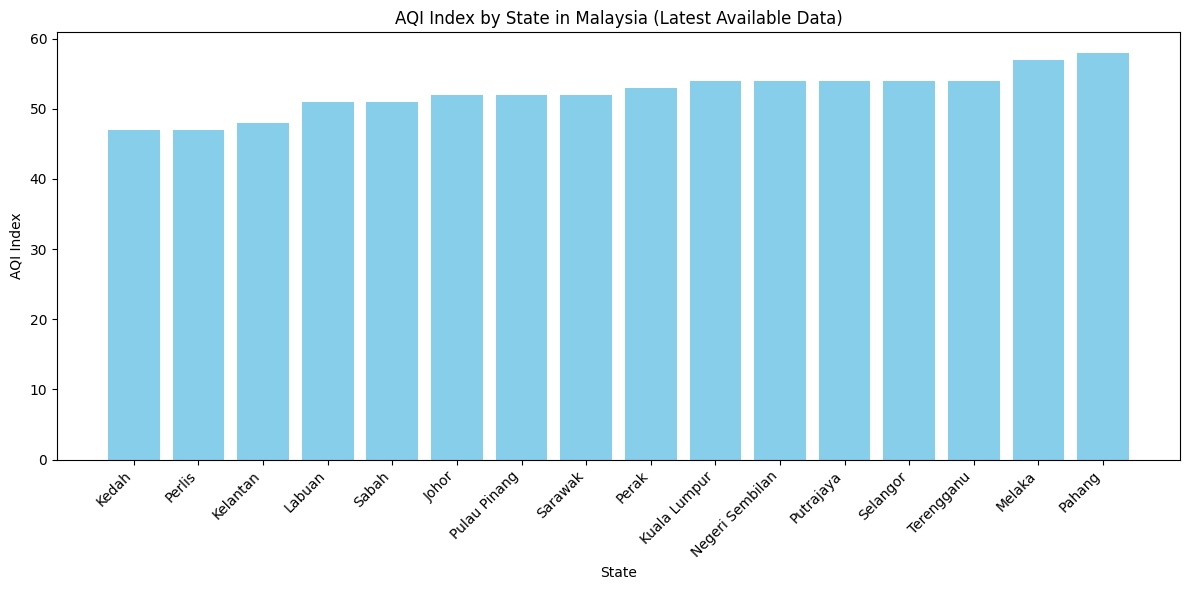

In [28]:
# Data from the previous response
data = {
    'Johor': 52,
    'Kedah': 47,
    'Kelantan': 48,
    'Kuala Lumpur': 54,
    'Labuan': 51,
    'Melaka': 57,
    'Negeri Sembilan': 54,
    'Pahang': 58,
    'Perak': 53,
    'Perlis': 47,
    'Pulau Pinang': 52,
    'Putrajaya': 54,
    'Sabah': 51,
    'Sarawak': 52,
    'Selangor': 54,
    'Terengganu': 54
}

# Sort the data by AQI value
sorted_data = sorted(data.items(), key=lambda x: x[1])
states = [item[0] for item in sorted_data]
aqi_values = [item[1] for item in sorted_data]

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust size as needed
plt.bar(states, aqi_values, color='skyblue')
plt.xlabel('State')
plt.ylabel('AQI Index')
plt.title('AQI Index by State in Malaysia (Latest Available Data)')
plt.xticks(rotation=45, ha='right')  # Rotate state names for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

It actually works! What a powerful agent it is!

Now let us view the logs to see the chat history.

In [29]:
view_logs()

---
[2025-04-19T10:37:22.593147] (text_with_grounding)
Input: Nice, is there any NGOs on this field?
Output: Yes, there are several NGOs (Non-Governmental Organizations) in Malaysia that are working on issues related to air pollution and haze. Here are a few examples:

*   **Greenpeace Malaysia:** Greenpeace Malaysia is actively involved in addressing haze and air pollution issues. They work to get clean, ...
Latency: 4.44s

---
[2025-04-19T10:36:32.835235] (text_with_grounding)
Input: Is there any way that I can know about government's resources on how to cope against the haze?
Output: Yes, there are several ways to access information about government resources for coping with haze in Malaysia:

**1. National Haze Action Plan:**

*   The Malaysian government has a National Haze Action Plan that outlines specific tasks for various agencies based on air quality levels.
*   This plan...
Latency: 5.30s

---
[2025-04-19T10:35:57.004259] (text_with_grounding)
Input: Can I know what are the 

There you have it! That's the bot, Robert that I built to provide the most updated, modern insights and suggestions about air pollution to the user. Any ideas on improving it do let me know! I will try to fine tune and make it even better😄

Made possible by: Wong Hoong Liang

Thanks Kaggle for the 5 day Intensive GenAI course so that I can build this project on my own, of course with some help from GenAI to help build the programs for this agent as well.😂

# **Contact Me!**

Let's connect!
https://www.linkedin.com/in/wong-hoong-liang-57124530a/

My Github (I will upload the codes for the course and this project):
https://github.com/RWong09